This is a demonstration of RECTE reduction to remove ramp effect in the HST light curves. We apply the correction to the TRAPPIST-1 observations (firstly published in De Wit et al. 2016). The result of this demosntration is published in Zhang et al. (2018)

# Preparation
The light curve for each wavelength channel needs to be extracted from the observation ima frame before applying the RECTE correction (or any other types of ramp effect correction). The reference for this procedures is Deming et al. (2013). Light curves are prepared for this demonstration and stored in pickle file "". 

We first plot the extracted light curves, without applying any correction. The characteristic ramp is visible in every light curve, and these ramps have stronger amplitude at the first orbits of the observations. We can see some other features in these ligth curves:  
1. Except for the first orbit light curves, the HST-orbital-variations of the ramp systematics are still visible. Comparing the light curves for the second orbit and that for the last orbit, the ramp amplitudes for the second orbit are stronger. This features shows the process of charge trapping lasting through the entire observations, especially for a faint host star such as TRAPPIST-1.
2. Channel-variation of the the ramp systematics are also visible. TRAPPIST-1, being an M8 star, has a signficant 1.4 $\mu$m water feature in its 1.1 to 1.7 $\mu$m spectrum. This water feature introduces flux intensity variations between channels. From the charge trapping perspective, flux intensity variations lead to different charge trapping rate between different channels, and thus differnt ramp profiles.
RECTE model considers these aspects in the corrections and provides a physically-motivated solution.

## Demonstration of the uncorrected light curves

In [1]:
import pickle
import shelve
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# restore light curve array from 
DBFileName = './binned_lightcurves_visit_01.shelve'
saveDB = shelve.open(DBFileName)
LCarray = saveDB['LCmat']
ERRarray = saveDB['Errmat']
time = saveDB['time']
wavelength = saveDB['wavelength']
orbit = saveDB['orbit']
expTime = saveDB['expTime']

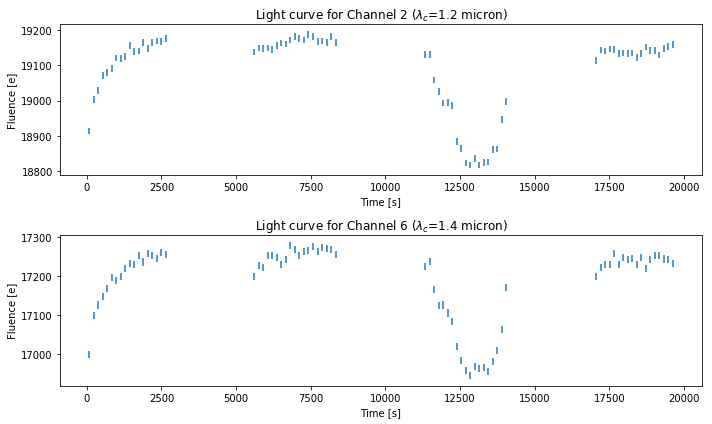

In [20]:
# plot light curve of the second channel and the sixth channel
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(211)
ax1.errorbar(time, LCarray[1, :], yerr=ERRarray[1, :], ls='none')
ax1.set_title('Light curve for Channel 2 ($\lambda_c$={0:.2} micron)'.format(wavelength[1]))
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Fluence [e]')
ax2 = fig1.add_subplot(212)
ax2.errorbar(time, LCarray[5, :], yerr=ERRarray[5, :], ls='none')
ax2.set_title('Light curve for Channel 6 ($\lambda_c$={0:.2} micron)'.format(wavelength[6]))
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Fluence [e]')
fig1.tight_layout()

Now let's write a function to remove the systemacts from the lightcurves

In [5]:
from RECTE import RECTE
from lmfit import Parameters, Model

def rampProfile2(crate1, slope1, crate2, slope2, dTrap_s, dTrap_f, trap_pop_s,
                 trap_pop_f, tExp, expTime, scanDirect):
    """Ramp profile for bi-directional scan And RECTE model parameters:

    :param crate1: average count rate in electron/second for two
    directions
    :param slope1: visit-long slope for two directions
    :param crate2: average count rate in electron/second for two directions
    :param slope2: visit-long slope for two directions
    :param dTrap_s: extra trapped slow charges between orbits
    :param dTrap_f: extra trapped fast charges between orbits
    :param trap_pop_s: initially trapped slow charges
    :param trap_pop_f: initially trapped fast charges
    :param tExp: beginning of each exposure
    :param expTime: exposure time
    :param scanDirect: scan direction (0 or 1) for each exposure
    :returns: observed counts
    :rtype: numpy.array

    """
    tExp = (tExp - tExp[0])
    upIndex, = np.where(scanDirect == 0)
    downIndex, = np.where(scanDirect == 1)
    cRates = np.zeros_like(tExp, dtype=float)
    cRates[upIndex] = (crate1 * (1 + tExp * slope1 / 1e7) / expTime)[upIndex]
    cRates[downIndex] = (crate2 *
                         (1 + tExp * slope2 / 1e7) / expTime)[downIndex]
    obsCounts = RECTE(
        cRates,
        tExp,
        expTime,
        trap_pop_s,
        trap_pop_f,
        dTrap_f=[dTrap_f],
        dTrap_s=[dTrap_s],
        dt0=[0],
        lost=0,
        mode='scanning')
    return obsCounts


def RECTECorrector2(t, orbits, counts, p, expTime, scanDirect, orbits_inTransit):
    """correct the RECTE model for one directional scan observations

    :param t: time stamps of the exposures
    :param orbits: orbit number of the exposures
    :param counts: observed counts
    :param p: Parameters objects to fit
    :param expTime: exposure time
    :param scanDirect: scan direction (0 or 1) for each exposure
    :returns: RECTE profile for correciting the light curve, best fit
    count rate array, RECTE output, slope
    :rtype: tuple of four numpy array

    """
    upIndex, = np.where(scanDirect == 0)
    downIndex, = np.where(scanDirect == 1)
    p = p.copy()
    p.add('crate1', value=counts.mean(), vary=True)
    p.add('crate2', value=counts.mean(), vary=True)
    p.add('slope1', value=0, min=-5, max=5, vary=True)
    p.add('slope2', value=0, min=-5, max=5, vary=True)
    rampModel2 = Model(
        rampProfile2, independent_vars=['tExp', 'expTime', 'scanDirect'])
    # model fit, obtain crate, and transit parameter,
    # but ignore transit para for this time
    t0 = t - t[0]  # make the first element in time array 0
    weights = np.ones_like(t)
    # if not inlucde the transit orbit,
    weights[np.in1d(orbits, orbits_inTransit)] = 0
    fitResult = rampModel2.fit(
        counts,
        tExp=t0,
        expTime=expTime,
        scanDirect=scanDirect,
        weights=weights,
        params=p,
        method='powell')
    # m = batman.TransitModel(transit_params, tBJD + 0.5 * expTime / 86400,
    #                         supersample_factor=9, exp_time=expTime/86400)
    counts_fit = np.zeros_like(counts, dtype=float)
    counts_fit[upIndex] = (fitResult.params['crate1'].value * (
        1 + t0 * fitResult.params['slope1'] / 1e7))[upIndex]
    counts_fit[downIndex] = (fitResult.params['crate2'].value * (
        1 + t0 * fitResult.params['slope2'] / 1e7))[downIndex]
    RECTE_out = fitResult.best_fit
    RECTE_in = np.zeros_like(RECTE_out)
    RECTE_in[upIndex] = fitResult.params['crate1'].value * (
        1 + t0[upIndex] * fitResult.params['slope1'] / 1e7)
    RECTE_in[downIndex] = fitResult.params['crate2'].value * (
        1 + t0[downIndex] * fitResult.params['slope2'] / 1e7)
    correctTerm = RECTE_out / RECTE_in
    slopes = np.zeros_like(RECTE_out)
    slopes[upIndex] = 1 + t0[upIndex] * fitResult.params['slope1'] / 1e7
    slopes[downIndex] = 1 + t0[downIndex] * fitResult.params['slope2'] / 1e7
    crates = np.zeros_like(RECTE_out)
    crates[upIndex] = fitResult.params['crate1'] * slopes[upIndex]
    crates[downIndex] = fitResult.params['crate2'] * slopes[downIndex]
    return correctTerm, crates, RECTE_out, slopes

def deRamp(pDeRamp,
           time,
           LCArray,
           ErrArray,
           orbits,
           expTime,
           scanDirect,
           twoDirect=False):
    """
    fit transit models
    deRECTE for a visit
    """
    nLC = LCArray.shape[0]  # number of light curves
    deRampArray = LCArray.copy()
    deRampErrArray = ErrArray.copy()
    modelArray = LCArray.copy()
    crateArray = LCArray.copy()
    slopeArray = LCArray.copy()
    p = pDeRamp.copy()
    for i in range(nLC):
        correctTerm, crate, bestfit, slope = RECTECorrector2(
            time, orbits, LCArray[i, :], p, expTime/1000, scanDirect, np.array([2]))
        deRampArray[i, :] = LCArray[i, :] / correctTerm / (crate)
        deRampErrArray[i, :] = ErrArray[i, :] / correctTerm / (crate)
        modelArray[i, :] = bestfit
        crateArray[i, :] = crate
        slopeArray[i, :] = slope
    return deRampArray, deRampErrArray, modelArray, crateArray, slopeArray

In [6]:
import pandas as pd
import numpy as np

infoFN = './TRAPPIST_Info.csv'
info = pd.read_csv(infoFN)
grismInfo = info[info['Filter'] == 'G141']
scanDirect = grismInfo['ScanDirection'].values
p = Parameters()
p.add('trap_pop_s', value=0, min=0, max=200, vary=True)
p.add('trap_pop_f', value=0, min=0, max=100, vary=True)
p.add('dTrap_f', value=0, min=0, max=200, vary=True)
p.add('dTrap_s', value=50, min=0, max=100, vary=True)
LCarray_noRamp, ERRarray_noRamp, Modelarray, cratearray, slopearray = deRamp(
    p, 
    time, 
    LCarray, 
    ERRarray, 
    orbit, 
    expTime,
    scanDirect)

Now, plot the result

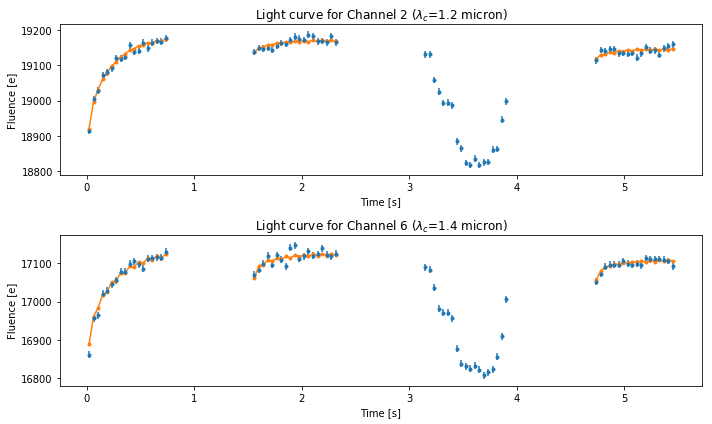

In [19]:
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(211)

ax1.errorbar(
    time / 3600,
    LCarray[1, :],
    yerr=ERRarray[1, :],
    fmt='.',
    ls='')
for o in [0, 1, 3]:
    ax1.plot(
        time[orbit == o] / 3600,
        Modelarray[1, orbit == o],
        '.-',
        color='C1')
ax1.set_title('Light curve for Channel 2 ($\lambda_c$={0:.2} micron)'.format(wavelength[1]))
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Fluence [e]')

ax2 = fig2.add_subplot(212)
ax2.errorbar(
    time / 3600,
    LCarray[6, :],
    yerr=ERRarray[6, :],
    fmt='.',
    ls='')
for o in [0, 1, 3]:
    ax2.plot(
        time[orbit == o] / 3600,
        Modelarray[6, orbit == o],
        '.-',
        color='C1')
ax2.set_title('Light curve for Channel 6 ($\lambda_c$={0:.2} micron)'.format(wavelength[6]))
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Fluence [e]')
fig2.tight_layout()

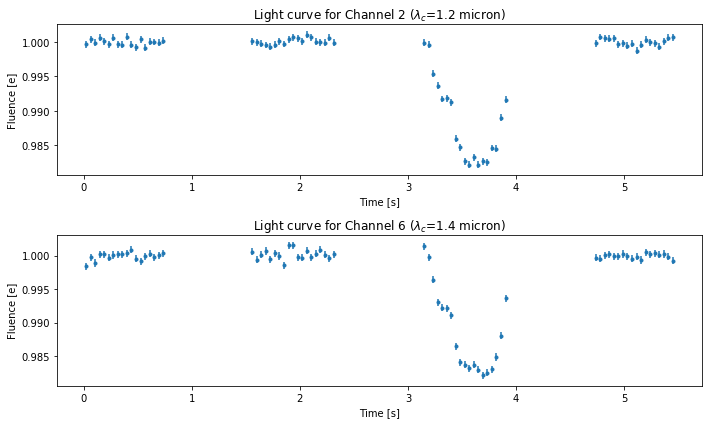

In [18]:
fig3 = plt.figure(figsize=(10, 6))
ax1 = fig3.add_subplot(211)

ax1.errorbar(
    time / 3600,
    LCarray_noRamp[1, :],
    yerr=ERRarray_noRamp[1, :],
    fmt='.',
    ls='')
ax1.set_title('Light curve for Channel 2 ($\lambda_c$={0:.2} micron)'.format(wavelength[1]))
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Fluence [e]')

ax2 = fig3.add_subplot(212)
ax2.errorbar(
    time / 3600,
    LCarray_noRamp[6, :],
    yerr=ERRarray_noRamp[6, :],
    fmt='.',
    ls='')

ax2.set_title('Light curve for Channel 6 ($\lambda_c$={0:.2} micron)'.format(wavelength[6]))
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Fluence [e]')
fig3.tight_layout()